# Setu Up

In [1]:
# Librerías para manejo de datos
import pandas as pd
import numpy as np

# Librerías para visualización de datos
import matplotlib.pyplot as plt
import seaborn as sns

# Librerías para preprocesamiento de datos
from sklearn.preprocessing import StandardScaler

# Librerías para entrenamiento y evaluación de modelos
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

# Librerías para división del conjunto de datos y búsqueda de hiperparámetros
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV

# Librerías para métricas de evaluación de modelos
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Librerías para reducción de dimensionalidad
from sklearn.decomposition import PCA

# Creating the classes

In [6]:
# Clase para exploración de datos (DataExplorer)
class DataExplorer:
    
    def __init__(self, file_path):
        self.file_path = file_path
        self.df_encoded = None
    
    # Cargar y preprocesar los datos
    def load_and_preprocess_data(self):
        df = pd.read_csv(self.file_path)
        df_clean = df.drop_duplicates()
        
        # Aplicar One-Hot Encoding
        df_encoded = pd.get_dummies(df_clean, drop_first=True)
        
        # Normalizar la variable numérica 'Age'
        scaler = StandardScaler()
        df_encoded['Age'] = scaler.fit_transform(df_encoded[['Age']])
        
        self.df_encoded = df_encoded
    
    # Visualización de la distribución de una variable numérica
    @staticmethod
    def plot_distribution(df, column):
        plt.figure(figsize=(8, 6))
        sns.histplot(df[column], kde=True, bins=20)
        plt.title(f'Distribución de la variable {column}')
        plt.xlabel(column)
        plt.ylabel('Frecuencia')
        plt.show()

    # Visualización de la relación entre variables categóricas y la variable objetivo
    @staticmethod
    def plot_categorical_relation(df, categorical_column, target_column):
        plt.figure(figsize=(8, 6))
        sns.countplot(x=categorical_column, hue=target_column, data=df)
        plt.title(f'Relación entre {categorical_column} y {target_column}')
        plt.xlabel(categorical_column)
        plt.ylabel('Frecuencia')
        plt.show()

    # Visualización del mapa de calor de correlación
    @staticmethod
    def plot_correlation_matrix(df):
        plt.figure(figsize=(32, 30))
        correlation_matrix = df.corr()
        sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', linewidths=0.5)
        plt.title('Mapa de calor de correlación entre variables')
        plt.show()
    
    # Método para ejecutar todas las visualizaciones
    def run_visualizations(self):
        # Distribución de la variable numérica 'Age'
        self.plot_distribution(self.df_encoded, 'Age')
        # Distribución de la variable objetivo 'Recurred_Yes'
        self.plot_distribution(self.df_encoded, 'Recurred_Yes')
        # Relación entre variables categóricas y la variable objetivo
        self.plot_categorical_relation(self.df_encoded, 'Gender_M', 'Recurred_Yes')
      
        # Mapa de calor de correlación
        self.plot_correlation_matrix(self.df_encoded)


# Thiroyd Cancer Model

In [7]:
# Clase para el modelo predictivo (PredictiveThyroidModel)
class PredictiveThyroidModel:
    
    def __init__(self, df_encoded):
        self.df_encoded = df_encoded
        self.X_train = None
        self.X_test = None
        self.y_train = None
        self.y_test = None
    
    # Dividir los datos en entrenamiento y prueba
    def split_data(self, target_column='Recurred_Yes'):
        X = self.df_encoded.drop(columns=[target_column])
        y = self.df_encoded[target_column]
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Función para optimizar hiperparámetros
    @staticmethod
    def hyperparameter_tuning(model, param_grid, X_train, y_train, search_type='grid'):
        if search_type == 'grid':
            search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, verbose=2, n_jobs=-1)
        elif search_type == 'random':
            search = RandomizedSearchCV(estimator=model, param_distributions=param_grid, n_iter=50, 
                                        cv=5, verbose=2, random_state=42, n_jobs=-1)
        search.fit(X_train, y_train)
        return search.best_params_, search.best_estimator_

    # Función para entrenar un modelo
    @staticmethod
    def train_model(model, X_train, y_train):
        model.fit(X_train, y_train)
        return model

    # Función para predecir y evaluar un modelo
    @staticmethod
    def evaluate_model(model, X_test, y_test):
        y_pred = model.predict(X_test)
        print("Resultados:")
        print(classification_report(y_test, y_pred))
        print("Matriz de Confusión:")
        print(confusion_matrix(y_test, y_pred))
        return accuracy_score(y_test, y_pred)
    
    # Método principal para entrenar y optimizar los modelos
    def run_model_optimization(self):
        # Hiperparámetros para Random Forest
        rf_param_grid = {
            'n_estimators': [100, 300, 500],
            'max_depth': [10, 20, 40],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 4],
            'bootstrap': [True, False]
        }
        # Hiperparámetros para Regresión Logística
        log_reg_param_grid = {
            'C': [0.01, 0.1, 1, 10, 100],
            'penalty': ['l2'],
            'solver': ['newton-cg', 'lbfgs', 'liblinear']
        }
        # Hiperparámetros para Árbol de Decisión
        tree_param_grid = {
            'max_depth': [10, 20, 30, None],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 4]
        }
        
        # Optimizar y evaluar Random Forest
        print("\nRandom Forest - Optimización:")
        rf_best_params, rf_best_model = self.hyperparameter_tuning(RandomForestClassifier(random_state=42), rf_param_grid, self.X_train, self.y_train, search_type='random')
        print(f"Mejores hiperparámetros para Random Forest: {rf_best_params}")
        self.evaluate_model(rf_best_model, self.X_test, self.y_test)
        
        # Optimizar y evaluar Regresión Logística
        print("\nRegresión Logística - Optimización:")
        log_reg_best_params, log_reg_best_model = self.hyperparameter_tuning(LogisticRegression(max_iter=1000), log_reg_param_grid, self.X_train, self.y_train, search_type='grid')
        print(f"Mejores hiperparámetros para Regresión Logística: {log_reg_best_params}")
        self.evaluate_model(log_reg_best_model, self.X_test, self.y_test)
        
        # Optimizar y evaluar Árbol de Decisión
        print("\nÁrbol de Decisión - Optimización:")
        tree_best_params, tree_best_model = self.hyperparameter_tuning(DecisionTreeClassifier(random_state=42), tree_param_grid, self.X_train, self.y_train, search_type='grid')
        print(f"Mejores hiperparámetros para Árbol de Decisión: {tree_best_params}")
        self.evaluate_model(tree_best_model, self.X_test, self.y_test)

# Executing the code

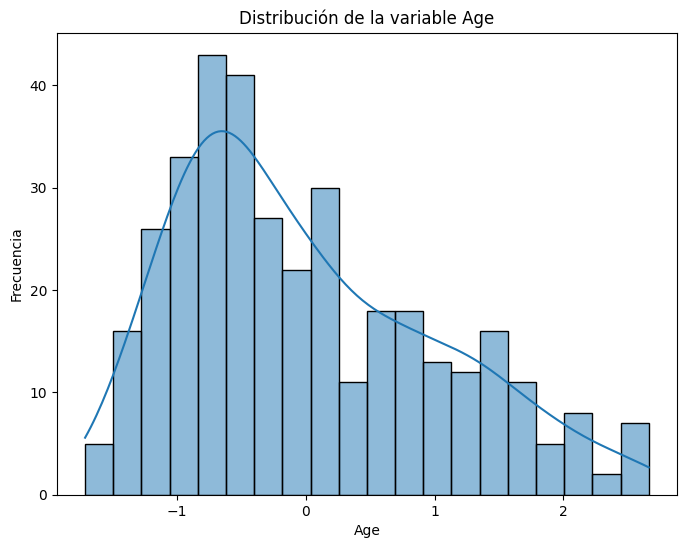

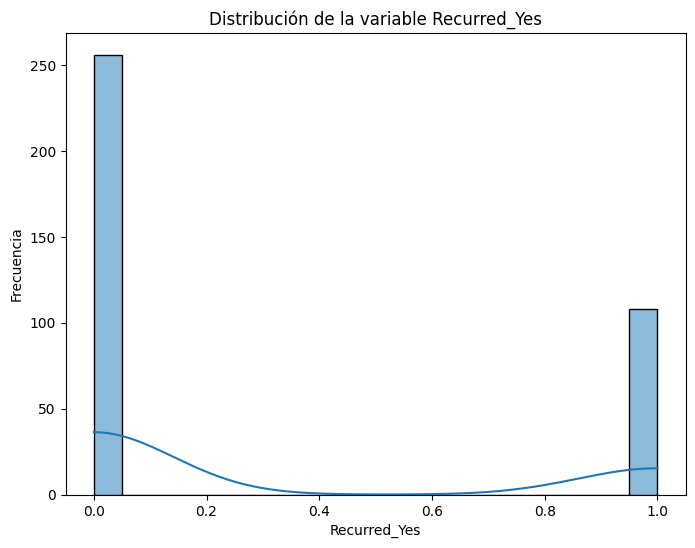

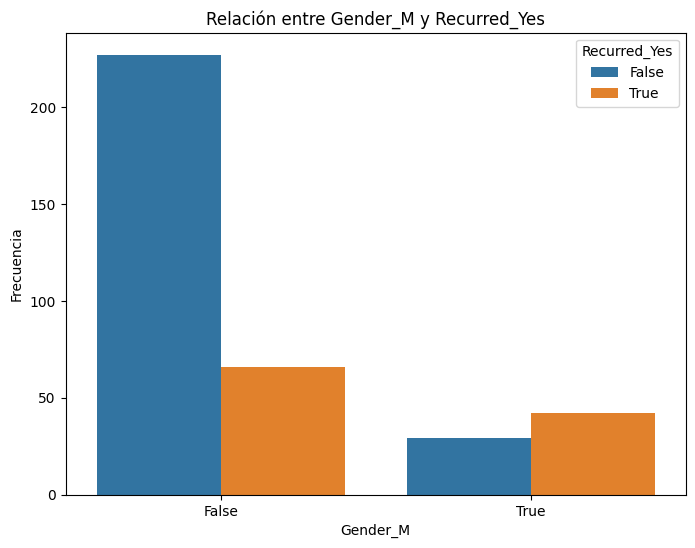

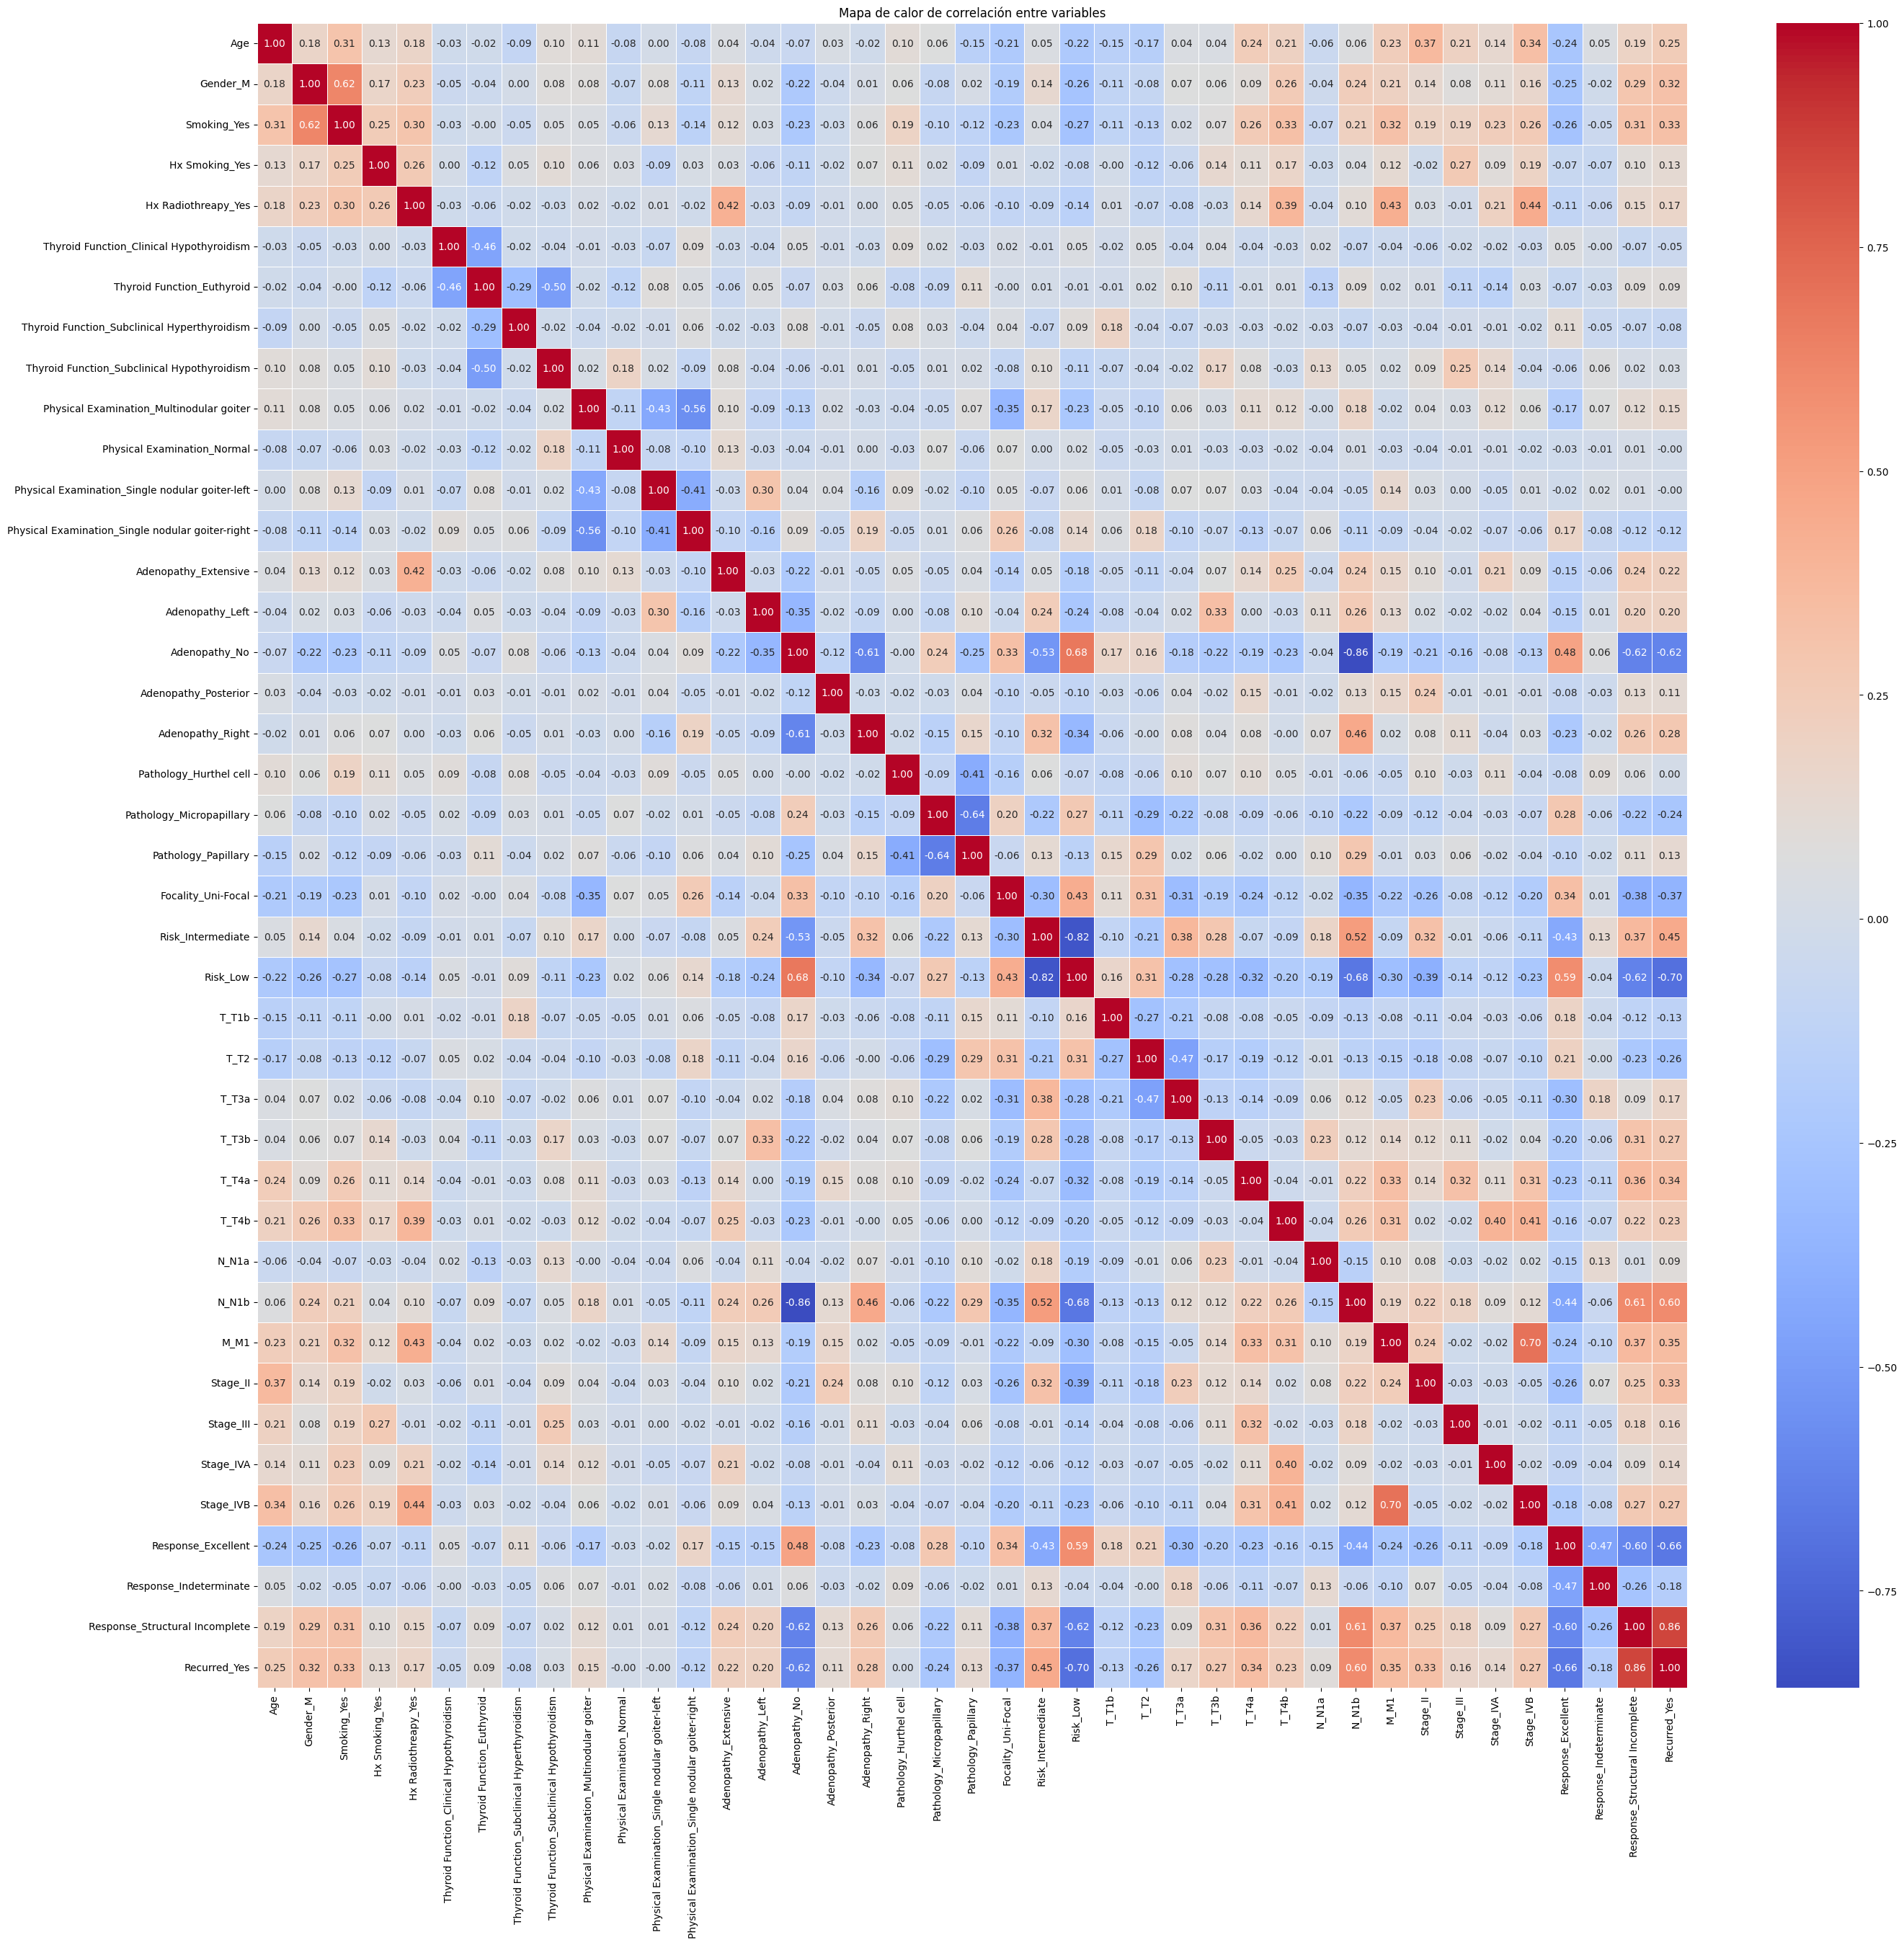


Random Forest - Optimización:
Fitting 5 folds for each of 50 candidates, totalling 250 fits
Mejores hiperparámetros para Random Forest: {'n_estimators': 100, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_depth': 40, 'bootstrap': False}
Resultados:
              precision    recall  f1-score   support

       False       0.96      0.98      0.97        51
        True       0.95      0.91      0.93        22

    accuracy                           0.96        73
   macro avg       0.96      0.94      0.95        73
weighted avg       0.96      0.96      0.96        73

Matriz de Confusión:
[[50  1]
 [ 2 20]]

Regresión Logística - Optimización:
Fitting 5 folds for each of 15 candidates, totalling 75 fits
Mejores hiperparámetros para Regresión Logística: {'C': 10, 'penalty': 'l2', 'solver': 'liblinear'}
Resultados:
              precision    recall  f1-score   support

       False       0.96      0.98      0.97        51
        True       0.95      0.91      0.93        22

    

In [8]:
    file_path = '../data/raw/Thyroid_Diff.csv'  # Cambia la ruta al archivo CSV
    explorer = DataExplorer(file_path)
    explorer.load_and_preprocess_data()
    explorer.run_visualizations()

    # Predicción y optimización de modelos
    model = PredictiveThyroidModel(explorer.df_encoded)
    model.split_data()
    model.run_model_optimization()